In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score

import biosppy as biosppy

import pywt

from sklearn.preprocessing import normalize

from scipy import stats
from statistics import pstdev,variance

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [34]:
def feature_output_csv(name, data, dimension = 1):
    df_X_test = pd.DataFrame(np.array(data).reshape(-1,dimension))
    path = "./Feature/"+name+".csv"
    df_X_test.to_csv(path, index=False)
    
def feature_output_test_csv(name, data, dimension = 1):
    df_X_test = pd.DataFrame(np.array(data).reshape(-1,dimension))
    path = "./TestFeature/"+name+".csv"
    df_X_test.to_csv(path, index=False)

In [2]:
xtrain = pd.read_csv("public/X_train.csv")
xtrain.drop("id", axis=1, inplace = True)

xtest =  pd.read_csv("public/X_test.csv")
xtest.drop("id", axis=1, inplace = True)

ytrain = pd.read_csv("public/y_train.csv")
ytrain.drop("id", axis=1, inplace = True)

print(xtrain.shape, xtest.shape, ytrain.shape)


dataset_x = np.array(xtrain)
dataset_y = np.array(ytrain)

(5117, 17842) (3411, 17842) (5117, 1)


In [57]:
dataset_x = np.array(xtrain)

In [58]:
# FFT, power, average and autocorrelation
a = dataset_x

autocorr = []
ptp = []
avg = []
fft=[]

for i in range(len(a)):

  h = a[i]
  h = h[~np.isnan(h)]

  h_series = pd.Series(h)
  corr = h_series.autocorr(lag=2)
  autocorr.append(corr)

  avg.append(np.average(h))
  ptp.append(np.ptp(h))

  f = np.fft.fft(h)
  array = f[0:800]
  n = 15
  indices = array.argsort()[-n:][::-1]
  fft.append(indices)

new_autocorr = np.transpose(np.array([autocorr]))
ptp = np.transpose(np.array([ptp]))
avg = np.transpose(np.array([avg]))
fft_np = np.array(fft)

In [71]:
fft_np.shape

(5117, 15)

In [72]:
feature_output_csv("fft", fft_np, 15)

In [73]:
feature_output_csv("autocorr", new_autocorr)

In [60]:
#Padding the sequence with the values in last row to max length
to_pad = 17841
new_seq = []
for one_seq in dataset_x:
    one_seq = one_seq[~np.isnan(one_seq)]
    len_one_seq = len(one_seq)
    last_val = one_seq[-1]
    n = to_pad - len_one_seq
    to_concat = np.repeat(0, n)
    new_one_seq = np.concatenate([one_seq, to_concat])
    new_seq.append(new_one_seq)
final_seq = np.stack(new_seq)

dataset_x = np.asarray(final_seq)

In [61]:
# Extract using biosspy
ts_list = []
filtered_list=[]
rpeaks_list=[]
templates_ts_list=[]
templates_list=[]
heart_rate_ts_list=[]
heart_rate_list=[]

for i in range(len(dataset_x)):
    ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = biosppy.signals.ecg.ecg(signal=dataset_x[i], sampling_rate=300.0, show=False)
    filtered_list.append(filtered)
    rpeaks_list.append(rpeaks)
    templates_ts_list.append(templates_ts)
    templates_list.append(templates)
    heart_rate_ts_list.append(heart_rate_ts)
    heart_rate_list.append(heart_rate)
    ts_list.append(ts)

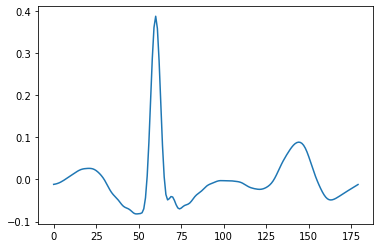

In [62]:
# Normalize the data and find the average characteristic heartbeat of each patient
normalized_templates=[]
patients_heartbeats = []
for i in range(len(templates_list)):
  normalized_templates.append(normalize(templates_list[i]))
  patients_heartbeats.append(sum(normalized_templates[i])/len(normalized_templates[i]))

plt.plot(patients_heartbeats[0])
plt.show()

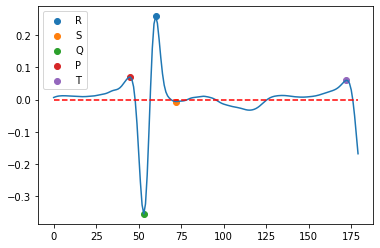

In [63]:
# Extarct all the peaks / Visualization
patient_current = patients_heartbeats[347]

# Find the peak
index = np.where(patient_current==max(patient_current))
R = index[0]

# First-half
first_half = patient_current[0:R[0]]
index = np.where(patient_current==min(first_half[R[0]-30:R[0]]))

Q = index[0]
index = np.where(first_half[0:Q[0]]==max(first_half[0:Q[0]]))
P = index[0]

#Second half
second_half = patient_current[R[0]+1:] 
index = np.where(patient_current==min(second_half[0:30]))
S = index[0]

second_half = second_half[S[0]-R[0]+1:]
index = np.where(patient_current==max(second_half))
T = index[0] 

plt.plot(patient_current)
plt.scatter(R,patient_current[R],label='R')
plt.scatter(S,patient_current[S],label='S')
plt.scatter(Q,patient_current[Q],label='Q')
plt.scatter(P,patient_current[P],label='P')
plt.scatter(T,patient_current[T],label='T')
plt.plot(np.arange(0, 180),np.zeros(180), 'r--') 
plt.legend()
plt.show()

In [67]:
# Extarct all the peaks 
P_list=[]
Q_list=[]
R_list=[]
S_list=[]
T_list=[]
U_list=[]
U_value_list = []

for i in range(len(patients_heartbeats)):

    patient_current = patients_heartbeats[i]

    # Find the peak
    index = np.where(patient_current==max(patient_current))
    R = index[0]

    # First-half
    first_half = patient_current[0:R[0]]
    index = np.where(patient_current==min(first_half[R[0]-30:R[0]]))
    Q = index[0]

    index = np.where(first_half[0:Q[0]]==max(first_half[0:Q[0]]))
    P = index[0]

    #Second half
    second_half = patient_current[R[0]+1:] 
    index = np.where(patient_current==min(second_half[0:30]))
    S = index[0]

    second_half = second_half[S[0]-R[0]+1:]
    index = np.where(patient_current==max(second_half))
    T = index[0] 

    last_tail = patient_current[(T[0]):] 
    index = np.where(patient_current==min(last_tail))
    U = index[0]
    U_list.append(U[0])
    U_value_list.append(patient_current[U[0]])

    P_list.append(P[0])
    Q_list.append(Q[0])
    R_list.append(R[0])
    S_list.append(S[0])
    T_list.append(T[0])
    
print("len of U_value_list: ", len(U_value_list))
print("len of U_list: ", len(U_list))

len of U_value_list:  5117
len of U_list:  5117


In [68]:
# Intervals and Ratios of peaks
PR_list = []
QRS_list = []
ST_list = []

for i in range(len(P_list)):
  PR_list.append(R_list[i]-P_list[i])
  QRS_list.append(S_list[i]-Q_list[i])
  ST_list.append(T_list[i]-S_list[i])

PR_list = np.array(PR_list).reshape(-1,1)
QRS_list = np.array(QRS_list).reshape(-1,1)
ST_list = np.array(ST_list).reshape(-1,1)
P_list = np.array(P_list).reshape(-1,1)
R_list = np.array(R_list).reshape(-1,1)
S_list = np.array(S_list).reshape(-1,1)
T_list = np.array(T_list).reshape(-1,1)

QRS_T_list= np.divide(QRS_list, T_list) 
QRS_P_list= np.divide(QRS_list, P_list) 
QRS_T_list=np.nan_to_num(QRS_T_list, nan=0.0,posinf=0.0, neginf=0.0)
QRS_P_list=np.nan_to_num(QRS_P_list, nan=0.0,posinf=0.0, neginf=0.0)

F:\Anaconda3\envs\TF_2G\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


In [69]:
PQRSTU = np.concatenate((
    np.array(PR_list).reshape(-1,1),
np.array(ST_list).reshape(-1,1),
np.array(P_list).reshape(-1,1),
np.array(Q_list).reshape(-1,1),
np.array(R_list).reshape(-1,1),
np.array(S_list).reshape(-1,1),
np.array(T_list).reshape(-1,1),
np.array(U_list).reshape(-1,1),
np.array(U_value_list).reshape(-1,1),
                    ), axis=1)

In [70]:
PQRSTU.shape
feature_output_csv("PQRSTU", PQRSTU,9)

In [51]:
ST_list

array([[67],
       [92],
       [80],
       ...,
       [55],
       [78],
       [59]], dtype=int64)

In [10]:
# Range, Mean and Median of amplitudes
max_A=[]
min_A=[]
mean_A=[]
median_A=[]

for i in range(len(patients_heartbeats)):

  patient_current = patients_heartbeats[i]

  max_A.append(max(patient_current))
  min_A.append(min(patient_current))
  mean_A.append(np.mean(patient_current))
  median_A.append(np.median(patient_current))

In [11]:
# Heart rates mean, median, variant and standard deviation
hr_mean=[]
hr_std=[]
hr_median=[]
hr_var = []

for i in range(len(heart_rate_list)):
    d =np.diff(heart_rate_list[i])
    hr_mean.append(np.mean(d))
    hr_std.append(np.std(d))
    hr_median.append(np.median(d))
    hr_var.append(np.mean(d)-np.var(d))
    
hr_mean=np.nan_to_num(hr_mean, nan=0.0)
hr_std=np.nan_to_num(hr_std, nan=0.0)
hr_median=np.nan_to_num(hr_median, nan=0.0)
hr_var=np.nan_to_num(hr_var, nan=0.0)

F:\Anaconda3\envs\TF_2G\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
F:\Anaconda3\envs\TF_2G\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
F:\Anaconda3\envs\TF_2G\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
F:\Anaconda3\envs\TF_2G\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
F:\Anaconda3\envs\TF_2G\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
F:\Anaconda3\envs\TF_2G\lib\site-packages\numpy\core\fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


In [12]:
# Timings of peaks mean, median, variant and standard deviation
ts_mean=[]
ts_std=[]
ts_median=[]
ts_var = []

for i in range(len(ts_list)):
    d =np.diff(ts_list[i])
    ts_mean.append(np.mean(d))
    ts_std.append(np.std(d))
    ts_median.append(np.median(d))
    ts_var.append(np.mean(d)-np.var(d))
    
ts_mean=np.nan_to_num(ts_mean, nan=0.0)
ts_std=np.nan_to_num(ts_std, nan=0.0)
ts_median=np.nan_to_num(ts_median, nan=0.0)
ts_var=np.nan_to_num(ts_var, nan=0.0)

In [13]:
# Timings of heart rates mean, median, variant and standard deviation
hr_ts_mean=[]
hr_ts_std=[]
hr_ts_median=[]
hr_ts_var = []

for i in range(len(heart_rate_ts_list)):
    d =np.diff(heart_rate_ts_list[i])
    hr_ts_mean.append(np.mean(d))
    hr_ts_std.append(np.std(d))
    hr_ts_median.append(np.median(d))
    hr_ts_var.append(np.mean(d)-np.var(d))
    
hr_ts_mean=np.nan_to_num(hr_ts_mean, nan=0.0)
hr_ts_std=np.nan_to_num(hr_ts_std, nan=0.0)
hr_ts_median=np.nan_to_num(hr_ts_median, nan=0.0)
hr_ts_var=np.nan_to_num(hr_ts_var, nan=0.0)

In [14]:
# Peaks mean, median, variant, mode and standard deviation
peaks_mean=[]
peaks_std=[]
peaks_median=[]
peaks_mode=[]
peaks_var = []

for i in range(len(rpeaks_list)):
    peaks_mean.append(np.mean(rpeaks_list[i]))
    peaks_std.append(np.std(rpeaks_list[i]))
    peaks_median.append(np.median(rpeaks_list[i]))
    peaks_mode.append(np.mean(rpeaks_list[i])-stats.mode(rpeaks_list[i])[0])
    peaks_var.append(np.var(rpeaks_list[i]))

In [15]:
# Peaks differences mean, median, variant, mode and standard deviation
diff_mean=[]
diff_std=[]
diff_median=[]
diff_mode=[]
diff_var = []
diff_dev = []

for i in range(len(rpeaks_list)):
    d = np.diff(rpeaks_list[i])
    diff_mean.append(np.mean(d))
    diff_std.append(np.std(d))
    diff_median.append(np.median(d))
    diff_mode.append(np.mean(d)-stats.mode(d)[0])
    diff_var.append(np.mean(d)-variance(d))
    diff_dev.append(np.mean(d)-pstdev(d))

diff_mean=np.nan_to_num(diff_mean, nan=0.0)
diff_std=np.nan_to_num(diff_std, nan=0.0)
diff_median=np.nan_to_num(diff_median, nan=0.0)
diff_mode=np.nan_to_num(diff_mode, nan=0.0)
diff_var=np.nan_to_num(diff_var, nan=0.0)
diff_dev=np.nan_to_num(diff_dev, nan=0.0)

In [53]:
# db2 coefficients
cA_list=[]
cD_list=[]

for i in range(len(patients_heartbeats)):
  cA, cD = pywt.dwt(patients_heartbeats[i], 'sym6', mode='periodic')

  cA_list.append(cA)
  cD_list.append(cD)

In [54]:
cD_list[0].shape

(95,)

In [55]:
Wavelets = np.concatenate((
                     cD_list,
                     cA_list,
                    ), axis=1)
Wavelets.shape

(3411, 190)

In [56]:
feature_output_test_csv("Wavelets_test", Wavelets,190)

In [17]:
# Energy of the signal
energy_list = []

for i in range(len(patients_heartbeats)):
  energy_list.append(np.sum(patients_heartbeats[i] ** 2))

In [18]:
# Prepare data
hr_mean = np.array(hr_mean).reshape(-1,1)
hr_std = np.array(hr_std).reshape(-1,1)
hr_median = np.array(hr_median).reshape(-1,1)
hr_var = np.array(hr_var).reshape(-1,1)
hr_ts_mean= np.array(hr_ts_mean).reshape(-1,1)
hr_ts_std= np.array(hr_ts_std).reshape(-1,1)
hr_ts_median= np.array(hr_ts_median).reshape(-1,1)
hr_ts_var= np.array(hr_ts_var).reshape(-1,1)
ts_mean= np.array(ts_mean).reshape(-1,1)
ts_std= np.array(ts_std).reshape(-1,1)
ts_median= np.array(ts_median).reshape(-1,1)
ts_var = np.array(ts_var).reshape(-1,1)
peaks_mean=np.array(peaks_mean).reshape(-1,1)
peaks_std=np.array(peaks_std).reshape(-1,1)
peaks_median=np.array(peaks_median).reshape(-1,1)
peaks_mode=np.array(peaks_mode).reshape(-1,1)
diff_mean=np.array(diff_mean).reshape(-1,1)
diff_std=np.array(diff_std).reshape(-1,1)
diff_median=np.array(diff_median).reshape(-1,1)
diff_mode=np.array(diff_mode).reshape(-1,1)
diff_var=np.array(diff_var).reshape(-1,1)
diff_dev=np.array(diff_dev).reshape(-1,1)
max_A=np.array(max_A).reshape(-1,1)
min_A=np.array(min_A).reshape(-1,1)
mean_A=np.array(mean_A).reshape(-1,1)
median_A=np.array(median_A).reshape(-1,1)
energy_list =np.array(energy_list).reshape(-1,1)
PR_list=np.array(PR_list).reshape(-1,1)
ST_list=np.array(ST_list).reshape(-1,1)
P_list=np.array(P_list).reshape(-1,1)
Q_list=np.array(Q_list).reshape(-1,1)
R_list=np.array(R_list).reshape(-1,1)
S_list=np.array(S_list).reshape(-1,1)
T_list=np.array(T_list).reshape(-1,1)
peaks_var=np.array(peaks_var).reshape(-1,1)
U_list =np.array(U_list).reshape(-1,1)
U_value_list =np.array(U_value_list).reshape(-1,1)

# Create data array of all the important extracted features
data=np.concatenate((fft_np, 
                     new_autocorr, 
                     ptp,
                     avg,
                     energy_list,
                     peaks_var,
                     peaks_mean, 
                     peaks_std, 
                     peaks_median, 
                     peaks_mode,   
                     T_list,
                     S_list,
                     R_list,
                     Q_list,
                     P_list,
                     ST_list,
                     QRS_list,
                     PR_list,
                     QRS_T_list,
                     QRS_P_list,
                     max_A-min_A,
                     mean_A,
                     median_A,
                     hr_std,
                     hr_mean,
                     hr_std,
                     hr_var,
                     hr_median,
                     
                     #冗余
#                      hr_ts_mean,
#                      hr_ts_std,
#                      hr_ts_median,
#                      hr_ts_var,
                     
                     cD_list,
                     cA_list,
                     diff_dev, 
                     diff_var, 
                     diff_std,
                     diff_mode, 
                     diff_mean, 
                     diff_median,
                     ts_mean,
                     ts_std,
                     ts_median,
                     ts_var,
                     
                     U_list,
                    U_value_list,
                     ), axis=1)
print (data.shape)

(5117, 244)


In [19]:
x_train, x_test, y_train, y_test = train_test_split(data, dataset_y, test_size=0.20, random_state=42)

clf = GradientBoostingClassifier(learning_rate=0.05, n_estimators=500, max_depth=7, 
                                 min_samples_split=60, min_samples_leaf=9, subsample=1.0,
                                 max_features=50, random_state=0)


print ('Training')
eval_set = [(x_test, y_test)]
clf.fit(x_train, y_train.ravel())
    
print ('Predicting')
predicted_labels = clf.predict(x_test)

print ('Scoring')
score = f1_score(y_test, predicted_labels, average='micro')

print('>%.3f' % score)

print ('Scoring')
confusion_matrix(y_test, predicted_labels)

Training
Predicting
Scoring
>0.801
Scoring


array([[550,   0,  42,   3],
       [  7,  55,  23,   1],
       [ 91,  10, 195,   6],
       [ 16,   0,   5,  20]], dtype=int64)

In [20]:
scores, members = list(), list()

repeat = 1 # number of times to do the k-fold cross validation
n_folds = 10 # of folds for the cross validation

models_list = []

for i in range(repeat):

  kfold = KFold(n_folds, True, i) # change seed each time
  
# cross validation
  for train_ix, test_ix in kfold.split(data, dataset_y):

    print("::::::::   # of Training Indices: ", train_ix.size,
          "::::::::::   # of Testing Indices: ", test_ix.size)

    # select samples
    x_train = []
    y_train = []
    x_test = []
    y_test = []

    for i in range(train_ix.size):
      x_train.append(data[train_ix[i]])
      y_train.append(dataset_y[train_ix[i]])

    for i in range(test_ix.size):
      x_test.append(data[test_ix[i]])
      y_test.append(dataset_y[test_ix[i]])

    y_train = np.array(y_train) 
    x_train = np.array(x_train)
    y_test = np.array(y_test) 
    x_tests= np.array(x_test) 

    print ('Training')
    clf = GradientBoostingClassifier(learning_rate=0.05, n_estimators=500, max_depth=7, 
                                    min_samples_split=60, min_samples_leaf=9, subsample=1,
                                    max_features=50, random_state=0)

    clf.fit(x_train, y_train.ravel())
    
    models_list.append(clf)
  
    print ('Predicting')
    predicted_labels = clf.predict(x_test)

    print ('Scoring')     
    score = f1_score(y_test, predicted_labels, average='micro')

    print('>%.3f' % score)
  
    scores.append(score)

::::::::   # of Training Indices:  4605 ::::::::::   # of Testing Indices:  512
Training


F:\Anaconda3\envs\TF_2G\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Predicting
Scoring
>0.812
::::::::   # of Training Indices:  4605 ::::::::::   # of Testing Indices:  512
Training
Predicting
Scoring
>0.828
::::::::   # of Training Indices:  4605 ::::::::::   # of Testing Indices:  512
Training
Predicting
Scoring
>0.807
::::::::   # of Training Indices:  4605 ::::::::::   # of Testing Indices:  512
Training
Predicting
Scoring
>0.859
::::::::   # of Training Indices:  4605 ::::::::::   # of Testing Indices:  512
Training
Predicting
Scoring
>0.836
::::::::   # of Training Indices:  4605 ::::::::::   # of Testing Indices:  512
Training
Predicting
Scoring
>0.834
::::::::   # of Training Indices:  4605 ::::::::::   # of Testing Indices:  512
Training
Predicting
Scoring
>0.797
::::::::   # of Training Indices:  4606 ::::::::::   # of Testing Indices:  511
Training
Predicting
Scoring
>0.816
::::::::   # of Training Indices:  4606 ::::::::::   # of Testing Indices:  511
Training
Predicting
Scoring
>0.793
::::::::   # of Training Indices:  4606 ::::::::::   #

In [21]:
sum(scores)

8.178525562622308

In [22]:
df_X_train = pd.DataFrame(data)
df_X_train.to_csv("X_train_feature_MY.csv", index=False)


# Train in the whole dataset for the final model

In [23]:
x_train = data
y_train = dataset_y

y_train = np.array(y_train) 
x_train= np.array(x_train) 

print ('Training in the whole dataset')
clf = GradientBoostingClassifier(learning_rate=0.05, n_estimators=500, max_depth=7, 
                                    min_samples_split=60, min_samples_leaf=9, subsample=1,
                                    max_features=50, random_state=0)

clf.fit(x_train, y_train.ravel())

Training in the whole dataset


GradientBoostingClassifier(learning_rate=0.05, max_depth=7, max_features=50,
                           min_samples_leaf=9, min_samples_split=60,
                           n_estimators=500, random_state=0, subsample=1)

In [24]:
# Exctract the Data

In [25]:
df = pd.read_csv('./public/X_test.csv', header=0)
dataset_x_test = df.copy()
array = np.array(dataset_x_test)

dataset_x_test.pop("id")
dataset_x_test = np.array(dataset_x_test)

a = dataset_x_test
autocorr = []
ptp = []
avg = []
fft = []

for i in range(len(a)):
  h = a[i]
  h = h[~np.isnan(h)]
  h_series = pd.Series(h)
  corr = h_series.autocorr(lag=2)
  autocorr.append(corr)
  avg.append(np.average(h))
  ptp.append(np.ptp(h))
  f = np.fft.fft(h)
  array = f[0:800]
  n = 15
  indices = array.argsort()[-n:][::-1]
  fft.append(indices)

new_autocorr = np.transpose(np.array([autocorr]))
ptp = np.transpose(np.array([ptp]))
avg = np.transpose(np.array([avg]))
fft_np = np.array(fft)

to_pad = 17841
new_seq = []
for one_seq in dataset_x_test:
    one_seq = one_seq[~np.isnan(one_seq)]
    len_one_seq = len(one_seq)
    last_val = one_seq[-1]
    n = to_pad - len_one_seq
    to_concat = np.repeat(0, n)
    new_one_seq = np.concatenate([one_seq, to_concat])
    new_seq.append(new_one_seq)
final_seq = np.stack(new_seq)
dataset_x_test = np.asarray(final_seq)

ts_list = []
filtered_list=[]
rpeaks_list=[]
templates_ts_list=[]
templates_list=[]
heart_rate_ts_list=[]
heart_rate_list=[]

for i in range(len(dataset_x_test)):
  ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = biosppy.signals.ecg.ecg(signal=dataset_x_test[i], sampling_rate=300.0, show=False)
  ts_list.append(ts)
  filtered_list.append(filtered)
  rpeaks_list.append(rpeaks)
  templates_ts_list.append(templates_ts)
  templates_list.append(templates)
  heart_rate_ts_list.append(heart_rate_ts)
  heart_rate_list.append(heart_rate)

######################################

normalized_templates=[]
patients_heartbeats = []
for i in range(len(templates_list)):
  normalized_templates.append(normalize(templates_list[i]))
  patients_heartbeats.append(sum(normalized_templates[i])/len(normalized_templates[i]))

P_list=[]
Q_list=[]
R_list=[]
S_list=[]
T_list=[]
U_list=[]
U_value_list = []

for i in range(len(patients_heartbeats)):

    patient_current = patients_heartbeats[i]

    # Find the peak
    index = np.where(patient_current==max(patient_current))
    R = index[0]

    # First-half
    first_half = patient_current[0:R[0]]
    index = np.where(patient_current==min(first_half[R[0]-30:R[0]]))
    Q = index[0]

    index = np.where(first_half[0:Q[0]]==max(first_half[0:Q[0]]))
    P = index[0]

    #Second half
    second_half = patient_current[R[0]+1:] 
    index = np.where(patient_current==min(second_half[0:30]))
    S = index[0]

    second_half = second_half[S[0]-R[0]+1:]
    index = np.where(patient_current==max(second_half))
    T = index[0] 

    last_tail = patient_current[(T[0]):] 
    index = np.where(patient_current==min(last_tail))
    U = index[0]
    U_list.append(U[0])
    U_value_list.append(patient_current[U[0]])

    P_list.append(P[0])
    Q_list.append(Q[0])
    R_list.append(R[0])
    S_list.append(S[0])
    T_list.append(T[0])

PR_list = []
QRS_list = []
ST_list = []

for i in range(len(P_list)):
  PR_list.append(R_list[i]-P_list[i])
  QRS_list.append(S_list[i]-Q_list[i])
  ST_list.append(T_list[i]-S_list[i])

  patient_current = patients_heartbeats[i]

PR_list = np.array(PR_list).reshape(-1,1)
QRS_list = np.array(QRS_list).reshape(-1,1)
ST_list = np.array(ST_list).reshape(-1,1)
P_list = np.array(P_list).reshape(-1,1)
R_list = np.array(R_list).reshape(-1,1)
S_list = np.array(S_list).reshape(-1,1)
T_list = np.array(T_list).reshape(-1,1)

QRS_T_list= np.divide(QRS_list, T_list) 
QRS_P_list= np.divide(QRS_list, P_list) 
QRS_T_list=np.nan_to_num(QRS_T_list, nan=0.0,posinf=0.0, neginf=0.0)
QRS_P_list=np.nan_to_num(QRS_P_list, nan=0.0,posinf=0.0, neginf=0.0)

max_A=[]
min_A=[]
mean_A=[]
median_A=[]

for i in range(len(patients_heartbeats)):
  patient_current = patients_heartbeats[i]
  max_A.append(max(patient_current))
  min_A.append(min(patient_current))
  mean_A.append(np.mean(patient_current))
  median_A.append(np.median(patient_current))

hr_mean=[]
hr_std=[]
hr_median=[]
hr_var = []

for i in range(len(heart_rate_list)):
    d =np.diff(heart_rate_list[i])
    hr_mean.append(np.mean(d))
    hr_std.append(np.std(d))
    hr_median.append(np.median(d))
    hr_var.append(np.mean(d)-np.var(d))

hr_mean=np.nan_to_num(hr_mean, nan=0.0)
hr_std=np.nan_to_num(hr_std, nan=0.0)
hr_median=np.nan_to_num(hr_median, nan=0.0)
hr_var=np.nan_to_num(hr_var, nan=0.0)

ts_mean=[]
ts_std=[]
ts_median=[]
ts_var = []

for i in range(len(ts_list)):
    d =np.diff(ts_list[i])
    ts_mean.append(np.mean(d))
    ts_std.append(np.std(d))
    ts_median.append(np.median(d))
    ts_var.append(np.mean(d)-np.var(d))
    
ts_mean=np.nan_to_num(ts_mean, nan=0.0)
ts_std=np.nan_to_num(ts_std, nan=0.0)
ts_median=np.nan_to_num(ts_median, nan=0.0)
ts_var=np.nan_to_num(ts_var, nan=0.0)

hr_ts_mean=[]
hr_ts_std=[]
hr_ts_median=[]
hr_ts_var = []

for i in range(len(heart_rate_ts_list)):
    d =np.diff(heart_rate_ts_list[i])
    hr_ts_mean.append(np.mean(d))
    hr_ts_std.append(np.std(d))
    hr_ts_median.append(np.median(d))
    hr_ts_var.append(np.mean(d)-np.var(d))
    
hr_ts_mean=np.nan_to_num(hr_ts_mean, nan=0.0)
hr_ts_std=np.nan_to_num(hr_ts_std, nan=0.0)
hr_ts_median=np.nan_to_num(hr_ts_median, nan=0.0)
hr_ts_var=np.nan_to_num(hr_ts_var, nan=0.0)

peaks_mean=[]
peaks_std=[]
peaks_median=[]
peaks_mode=[]
peaks_var = []

for i in range(len(rpeaks_list)):
    peaks_mean.append(np.mean(rpeaks_list[i]))
    peaks_std.append(np.std(rpeaks_list[i]))
    peaks_median.append(np.median(rpeaks_list[i]))
    peaks_mode.append(np.mean(rpeaks_list[i])-stats.mode(rpeaks_list[i])[0])
    peaks_var.append(np.var(rpeaks_list[i]))

diff_mean=[]
diff_std=[]
diff_median=[]
diff_mode=[]
diff_var = []
diff_dev = []

for i in range(len(rpeaks_list)):
    d = np.diff(rpeaks_list[i])
    diff_mean.append(np.mean(d))
    diff_std.append(np.std(d))
    diff_median.append(np.median(d))
    diff_mode.append(np.mean(d)-stats.mode(d)[0])
    diff_var.append(np.mean(d)-variance(d))
    diff_dev.append(np.mean(d)-pstdev(d))

diff_mean=np.nan_to_num(diff_mean, nan=0.0)
diff_std=np.nan_to_num(diff_std, nan=0.0)
diff_median=np.nan_to_num(diff_median, nan=0.0)
diff_mode=np.nan_to_num(diff_mode, nan=0.0)
diff_var=np.nan_to_num(diff_var, nan=0.0)
diff_dev=np.nan_to_num(diff_dev, nan=0.0)

cA_list=[]
cD_list=[]

for i in range(len(patients_heartbeats)):
    cA, cD = pywt.dwt(patients_heartbeats[i], 'sym6', mode='periodic')
    cA_list.append(cA)
    cD_list.append(cD)

energy_list = []

for i in range(len(patients_heartbeats)):
    energy_list.append(np.sum(patients_heartbeats[i] ** 2))

hr_mean = np.array(hr_mean).reshape(-1,1)
hr_std = np.array(hr_std).reshape(-1,1)
hr_median = np.array(hr_median).reshape(-1,1)
hr_var = np.array(hr_var).reshape(-1,1)
hr_ts_mean= np.array(hr_ts_mean).reshape(-1,1)
hr_ts_std= np.array(hr_ts_std).reshape(-1,1)
hr_ts_median= np.array(hr_ts_median).reshape(-1,1)
hr_ts_var= np.array(hr_ts_var).reshape(-1,1)
ts_mean= np.array(ts_mean).reshape(-1,1)
ts_std= np.array(ts_std).reshape(-1,1)
ts_median= np.array(ts_median).reshape(-1,1)
ts_var = np.array(ts_var).reshape(-1,1)
peaks_mean=np.array(peaks_mean).reshape(-1,1)
peaks_std=np.array(peaks_std).reshape(-1,1)
peaks_median=np.array(peaks_median).reshape(-1,1)
peaks_mode=np.array(peaks_mode).reshape(-1,1)
diff_mean=np.array(diff_mean).reshape(-1,1)
diff_std=np.array(diff_std).reshape(-1,1)
diff_median=np.array(diff_median).reshape(-1,1)
diff_mode=np.array(diff_mode).reshape(-1,1)
diff_var=np.array(diff_var).reshape(-1,1)
diff_dev=np.array(diff_dev).reshape(-1,1)
max_A=np.array(max_A).reshape(-1,1)
min_A=np.array(min_A).reshape(-1,1)
mean_A=np.array(mean_A).reshape(-1,1)
median_A=np.array(median_A).reshape(-1,1)
energy_list =np.array(energy_list).reshape(-1,1)
PR_list=np.array(PR_list).reshape(-1,1)
ST_list=np.array(ST_list).reshape(-1,1)
P_list=np.array(P_list).reshape(-1,1)
Q_list=np.array(Q_list).reshape(-1,1)
R_list=np.array(R_list).reshape(-1,1)
S_list=np.array(S_list).reshape(-1,1)
T_list=np.array(T_list).reshape(-1,1)
peaks_var=np.array(peaks_var).reshape(-1,1)
U_list = np.array(U_list).reshape(-1,1)
U_value_list = np.array(U_value_list).reshape(-1,1)





F:\Anaconda3\envs\TF_2G\lib\site-packages\ipykernel_launcher.py:137: RuntimeWarning: divide by zero encountered in true_divide
F:\Anaconda3\envs\TF_2G\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
F:\Anaconda3\envs\TF_2G\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
F:\Anaconda3\envs\TF_2G\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
F:\Anaconda3\envs\TF_2G\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
F:\Anaconda3\envs\TF_2G\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
F:\Anaconda3\envs\TF_2G\lib\site-packages\numpy\core\fromnumeric.py:3584: Ru

In [26]:
data=np.concatenate((fft_np, 
                     new_autocorr, 
                     ptp,
                     avg,
                     energy_list,
                     peaks_var,
                     peaks_mean, 
                     peaks_std, 
                     peaks_median, 
                     peaks_mode,   
                     T_list,
                     S_list,
                     R_list,
                     Q_list,
                     P_list,
                     ST_list,
                     QRS_list,
                     PR_list,
                     QRS_T_list,
                     QRS_P_list,
                     max_A-min_A,
                     mean_A,
                     median_A,
                     hr_std,
                     hr_mean,
                     hr_std,
                     hr_var,
                     hr_median,
#                      hr_ts_mean,
#                      hr_ts_std,
#                      hr_ts_median,
#                      hr_ts_var,
                     cD_list,
                     cA_list,
                     diff_dev, 
                     diff_var, 
                     diff_std,
                     diff_mode, 
                     diff_mean, 
                     diff_median,
                     ts_mean,
                     ts_std,
                     ts_median,
                     ts_var, 
                     U_list,
                     U_value_list,
                    ), axis=1)
print (data.shape)
#################################

predictions = clf.predict(data)

(3411, 244)


In [27]:
final_res = np.vstack((range(0,len(predictions)), predictions)).T
df_res = pd.DataFrame(final_res)
df_res.to_csv("our_result_fish2_featuremodification.csv", header = ["id", "y"], index=False)

In [28]:
data.shape

(3411, 244)

In [29]:
df_X_test = pd.DataFrame(data)
df_X_test.to_csv("X_test_feature_MY.csv", index=False)